In [57]:
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import RocCurveDisplay, plot_roc_curve

from fairlearn import datasets
from fairlearn.reductions import GridSearch
from fairlearn.reductions import DemographicParity, ErrorRate
from fairlearn.metrics import MetricFrame

In [58]:
def sensitive_pdfs(df, sensitive_features): 
    distinct_features_vals = []
    df_dict = {}
    for feature in sensitive_features:
        distinct_vals = set(df[feature].to_list())
        distinct_features_vals.append(distinct_vals)
    distinct_features_combos = list(product(*distinct_features_vals))
    for features in distinct_features_combos:
        query = " & ".join([f"{sensitive_features[i]} == '{features[i]}'" for i in range(len(sensitive_features))])
        filtered_df = df.query(query)
        key = tuple(sorted(features))
        df_dict[key] = filtered_df 
    return df_dict

In [59]:
def plot_auc(df, y_pred, y_true, name, ax=None):
    y_pred_r = np.asarray(df[y_pred]).astype(float)
    y_true_r = np.asarray(df[y_true]).astype(int)

    fpr, tpr, _ = roc_curve(y_true_r, y_pred_r, pos_label=1)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name)
    display.plot(ax=ax)
    return display

# Load data

In [60]:
# Load data
data = datasets.fetch_adult(as_frame=True)['data']
target = datasets.fetch_adult(as_frame=True)['target']

In [61]:
assert(len(target == len(data)))
print(len(target))
print(set(target))
data.head(3)
df = data.copy()

48842
{'<=50K', '>50K'}


# Run Model Example

In [62]:
# Extract into X, y and A
sensitive_features = ['sex', 'race']
data_cols = [x for x in data if x not in sensitive_features]

# Predictors
ohe = OneHotEncoder()
X = ohe.fit_transform(data[data_cols])

le = LabelEncoder()
y = le.fit_transform(target)
A = data[sensitive_features]

In [63]:
data.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States


In [64]:
# Split into test and train, making sure we have sequential indices in the results
X_train, X_test, y_train, y_test, A_train, A_test = \
    train_test_split(X, y, A, test_size=0.33, random_state=123)

# X_train = X_train.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)
# A_train = A_train.reset_index(drop=True)
# X_test = X_test.reset_index(drop=True)
# y_test = y_test.reset_index(drop=True)
# A_test = A_test.reset_index(drop=True)

No Skill: ROC AUC=0.500
Logistic Regression: ROC AUC=0.923


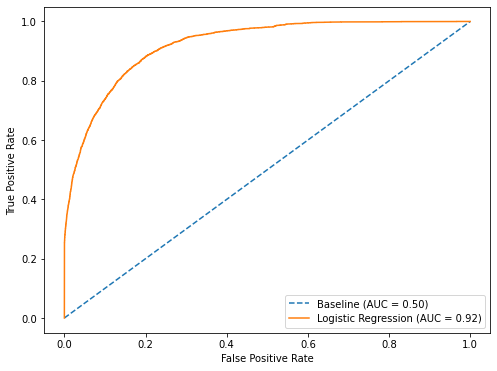

In [65]:
# Fit unmitigated model
clf = LogisticRegression(solver='liblinear', fit_intercept=True)
clf.fit(X_train, y_train)
y_score = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

# Get probabilies for positive prediction
y_score = y_score[:, 1]

# Get probabiliies for random (no skill)
ns_probs = [0 for n in range(len(y_test))]

# calculate AUC scores
ns_auc = roc_auc_score(y_test, ns_probs)
roc_auc = roc_auc_score(y_test, y_score)

# Summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic Regression: ROC AUC=%.3f' % (roc_auc))
 
# Get overall roc curve points
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
fpr, tpr, _ = roc_curve(y_test, y_score)

# Plot ROC curve

#figure, ax = plt.subplots()
plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline (AUC = 0.50)')
#display = plot_roc_curve(clf, X_test, y_test, sample_weight=None, drop_intermediate=True, response_method='auto', name="Logistic Regression", ax=ax, pos_label=1)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
display.plot(ax=ax)
plt.show()


# ROC Curves by Sensitive Values - Reference Code

In [66]:
# Concat predictions with sensitive values
y_true = y_test.copy()
pdf = pd.DataFrame({'y_true': y_true, 'y_score': y_score,'y_pred': y_pred,})
pdf = pd.concat([pdf, A_test.reset_index(drop=True)], axis=1)

# Generate grouped PDFs
# TO DO - Use metricframe class 

sensitive_pdfs_dict = sensitive_pdfs(pdf, sensitive_features)

In [67]:
sensitive_pdfs_dict[('Female',
  'Other')].head(3)

,y_true,y_score,y_pred,sex,race
297,0,0.167149,0,Female,Other
760,0,0.631803,1,Female,Other
832,0,0.001599,0,Female,Other


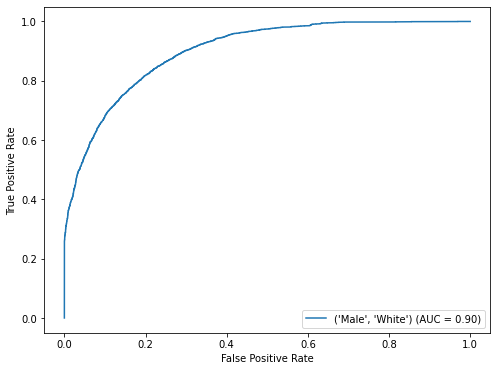

In [68]:
name = ('Male', 'White')
group = sensitive_pdfs_dict[name]
plt.figure(figsize=(8, 6))
ax = plt.gca()
group_plot = plot_auc(group,"y_score","y_true", name, ax)
plt.show()

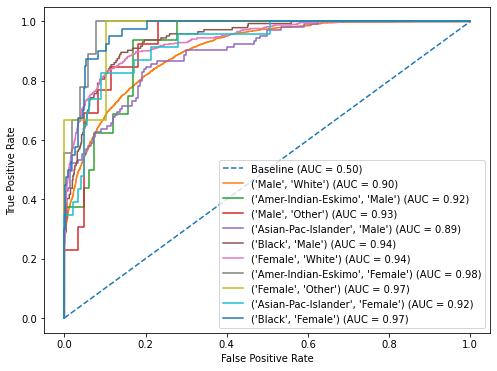

In [69]:
sensitive_pdfs_dict=sensitive_pdfs(pdf, sensitive_features)
plt.figure(figsize=(8, 6))
ax = plt.gca()
ns_probs = [0 for n in range(len(pdf))]
ns_auc = roc_auc_score(y_true, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
ax.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline (AUC = 0.50)')
for grouping in sensitive_pdfs_dict: 
    group_plot = plot_auc(sensitive_pdfs_dict[grouping],"y_score", "y_true", grouping, ax)

# ROC Curves by Sensitive Values - MetricFrame

In [70]:
def splitter(y_true, y_pred=y_score):
    # Ok this is non-intuitive, but it is caused by MetricFrame requiring y_pred. 
    # Passing y_score instead does not generate an error as MetricFrame also supports regression.  
    return (y_true, y_pred)

In [71]:
def plot_auc(y_true, y_score, name, ax=None, pos_label=1, **kwargs):
    """
    Plot auc curves. 
    """
    fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=pos_label, **kwargs)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name)
    display.plot(ax=ax)
    return display

In [73]:
roc_auc

0.9228475501209812

In [72]:
# Hmm. Passing y_score as y_pred could lead to issues later... but... 
mf = MetricFrame(splitter, y_true, y_pred=y_score, sensitive_features=A_test,
                 #sample_params = {'y_score': y_score}
                )
sensitive_series = mf.by_group

In [17]:
sensitive_series.index

MultiIndex([('Female', 'Amer-Indian-Eskimo'),
            ('Female', 'Asian-Pac-Islander'),
            ('Female',              'Black'),
            ('Female',              'Other'),
            ('Female',              'White'),
            (  'Male', 'Amer-Indian-Eskimo'),
            (  'Male', 'Asian-Pac-Islander'),
            (  'Male',              'Black'),
            (  'Male',              'Other'),
            (  'Male',              'White')],
           names=['sex', 'race'])

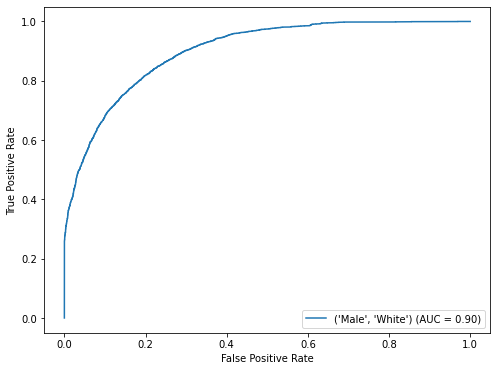

In [18]:
name = ('Male', 'White')
grp = sensitive_series[name]
grp_y_true = sensitive_series[name][0]
grp_y_score = sensitive_series[name][1]
plt.figure(figsize=(8, 6))
ax = plt.gca()
group_plot = plot_auc(y_true=grp_y_true, y_score=grp_y_score, name=name, ax=ax)
plt.show()

In [90]:
vars(group_plot)

{'estimator_name': ('Black', 'Female'),
 'fpr': array([0.        , 0.        , 0.        , 0.00135501, 0.00135501,
        0.00406504, 0.00406504, 0.00813008, 0.00813008, 0.01626016,
        0.01626016, 0.01761518, 0.01761518, 0.02574526, 0.02574526,
        0.03252033, 0.03252033, 0.03387534, 0.03387534, 0.04471545,
        0.04471545, 0.04742547, 0.04742547, 0.0501355 , 0.0501355 ,
        0.05420054, 0.05420054, 0.08265583, 0.08265583, 0.10298103,
        0.10298103, 0.11111111, 0.11111111, 0.14092141, 0.14092141,
        0.20325203, 0.20325203, 0.24119241, 0.24390244, 0.72899729,
        0.73170732, 0.98780488, 0.99051491, 1.        ]),
 'tpr': array([0.   , 0.025, 0.3  , 0.3  , 0.45 , 0.45 , 0.475, 0.475, 0.5  ,
        0.5  , 0.525, 0.525, 0.55 , 0.55 , 0.575, 0.575, 0.65 , 0.65 ,
        0.675, 0.675, 0.7  , 0.7  , 0.775, 0.775, 0.85 , 0.85 , 0.875,
        0.875, 0.9  , 0.9  , 0.925, 0.925, 0.95 , 0.95 , 0.975, 0.975,
        1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1. 

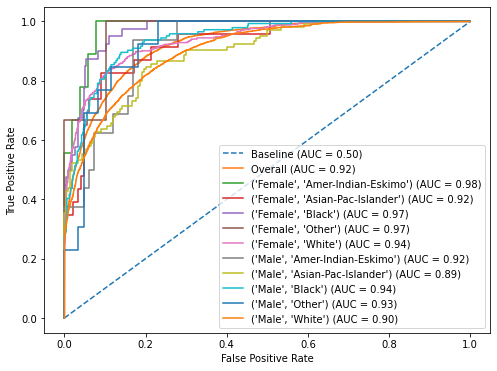

In [19]:
# Establish plot figure
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Plot baseline - 'no skill'
# i.e. performance of classifier is equivalent to random selection
ns_probs = [0 for n in range(len(pdf))]
ns_auc = roc_auc_score(y_true, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
ax.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline (AUC = 0.50)')

# Plot overall model performance
overall_auc = roc_auc_score(y_true, y_score)
overall_fpr, overall_tpr, _ = roc_curve(y_true, y_score)
ax.plot(overall_fpr, overall_tpr, label=f'Overall (AUC = {round(overall_auc, 2)})')

# Plot ROC Curves by group
for name in sensitive_series.index: 
    grp = sensitive_series[name]
    grp_y_true = sensitive_series[name][0]
    grp_y_score = sensitive_series[name][1]
    group_plot = plot_auc(y_true=grp_y_true, y_score=grp_y_score, name=name, ax=ax)
plt.show()

In [94]:
group_plot.ax_

<AxesSubplot:xlabel='False Positive Rate', ylabel='True Positive Rate'>

# ROC AUC

In [134]:
class roc_auc: 
    """
    Provides utilties for generating AUC scores, ROC curves
    and plotting ROC curves grouped by sensitive feature. 
    
    Parameters
    ----------
    y_true : List, pandas.Series, numpy.ndarray, pandas.DataFrame
        The ground-truth labels for classification. (i.e. results of clf.predict())
        
    y_score : List, pandas.Series, numpy.ndarray, pandas.DataFrame
        
    sensitive_features : List, pandas.Series, dict of 1d arrays, numpy.ndarray, pandas.DataFrame
        The sensitive features which should be used to create the subgroups.
        At least one sensitive feature must be provided.
        All names (whether on pandas objects or dictionary keys) must be strings.
        We also forbid DataFrames with column names of ``None``.
        For cases where no names are provided we generate names ``sensitive_feature_[n]``.
    """
    def __init__(self,
                 y_true, 
                 y_score, 
                 sensitive_features): 
        """
        Initiate class with required parameters to generate metric. 
        TODO: validate input
        """
        self.y_true = y_true
        self.y_score = y_score 
        self.sensitive_features = sensitive_features
        
    @staticmethod
    def splitter(y_true, y_pred): 
        """
        Placeholder function to enable splitting of dataframes using 
        existing MetricFrame class. 
        """
        return (y_true, y_pred)
    
    @staticmethod
    def plot_auc(y_true, y_score, name, ax=None, pos_label=1, **kwargs):
        """
        Plot AUC curves. 
        """      
        fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=pos_label, **kwargs)
        auc = auc(fpr, tpr)
        display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name=name)
        display.plot(ax=ax)
        return display
    
    def plot_baseline(self, ax=None, pos_label=1, **kwargs): 
        """
        Plot baseline indicator
        """
        
        # Generate plot figure, ax if not provided    
        if not ax: 
            figure, ax = plt.subplots()
        
        # Plot baseline - 'no skill'
        # i.e. performance of classifier is equivalent to random selection
        ns_probs = [0 for n in range(len(self.y_true))]
        baseline_auc = roc_auc_score(self.y_true, ns_probs)
        ns_fpr, ns_tpr, _ = roc_curve(self.y_true, ns_probs)
        ax.plot(
            ns_fpr, 
            ns_tpr, 
            linestyle='--',
            color='0.8',
            label=f'Baseline (AUC = {round(baseline_auc, 2)})'
               )
        return ax
    
    def plot_overall(self, ax=None, name='Overall', pos_label=1, **kwargs): 
        """
        Plot the overall performance of the model. 
        """
        # Generate plot figure, ax if not provided    
        if not ax: 
            figure, ax = plt.subplots()
            
        # Plot overall model performance 
        self.overall_auc = roc_auc_score(self.y_true, self.y_score)
        overall_fpr, overall_tpr, _ = roc_curve(self.y_true, self.y_score)
        ax.plot(overall_fpr, overall_tpr, label=f'Overall (AUC = {round(self.overall_auc, 2)})')
        return ax 
    
    def by_group(self): 
        """
        Splits data by sensitive feature subgroups. 
        See: Fairlearn.MetricFrame for more detail. 
        
        Note: MetricFrame requires y_pred (clf.predict). However, ROC curves and AUC scores 
        are generated using y_score (clf.predict_proba). 
        This method substitutes y_score (type:float) for y_pred (type:int) to conform to MetricFrame 
        required params. 
        (MetricFrame also supports regression and therefore allows values of type float to be 
        passed as y_pred.) 
        Admittedly this is a little weird. Alternately, you could pass `sample_params` to MetricFrame, 
        but not sure that's any cleaner. 
        """
        mf = MetricFrame(
            metric = self.splitter, 
            y_true = self.y_true, 
            y_pred = self.y_score, 
            sensitive_features = self.sensitive_features,
            #sample_params = {'y_score': y_score}
                        )
        self.sensitive_series = mf.by_group
        return self.sensitive_series
    
    def plot_by_group(
        self, 
        sensitive_index=None, 
        estimator_name = None,
        ax=None, 
        include_overall=False,
        include_baseline=False, 
                ): 
        """
        Plots ROC curve by sensitive feature subgroup. 
        
        
        """
        # Establish sensitive features
        if not sensitive_index: 
            sensitive_index = self.sensitive_series.index
            
        # Generate plot figure, ax if not provided    
        if not ax: 
            figure, ax = plt.subplots()
            
        # Set plot title to name of estimator 
        if estimator_name: 
            ax.set_title(estimator_name)
            
        # Plot baseline
        if include_baseline: 
            ax = self.plot_baseline(ax=ax)
        
        # Plot overall
        if include_overall: 
            ax = self.plot_overall(ax=ax)

        # Plot ROC Curves by group
        for name in sensitive_index: 
            grp = self.sensitive_series[name]
            grp_y_true = self.sensitive_series[name][0]
            grp_y_score = self.sensitive_series[name][1]
            group_plot = plot_auc(
                y_true=grp_y_true, 
                y_score=grp_y_score, 
                name=name, #apply subgroup name to legend label
                ax=ax
            )
     
        return ax 
    
    def auc_by_group(self, sensitive_index=None): 
        """
        Calculates AUC score by sensitive feature subgroups. 
        """
        # Establish sensitive features
        if not sensitive_index: 
            sensitive_index = self.sensitive_series.index
            
        self.auc_scores = {}
        for name in sensitive_index:
            grp = self.sensitive_series[name]
            grp_y_true = self.sensitive_series[name][0]
            grp_y_score = self.sensitive_series[name][1]
            grp_score = roc_auc_score(grp_y_true, grp_y_score)
            self.auc_scores[name] = grp_score 
        return self.auc_scores
        

## Default - No figure

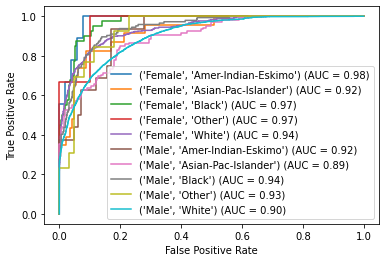

In [135]:
# Plot ROC curves by group
rc = roc_auc(y_true, y_score, A_test)
by_group = rc.by_group()
display = rc.plot_by_group()


## Default - Existing Figure

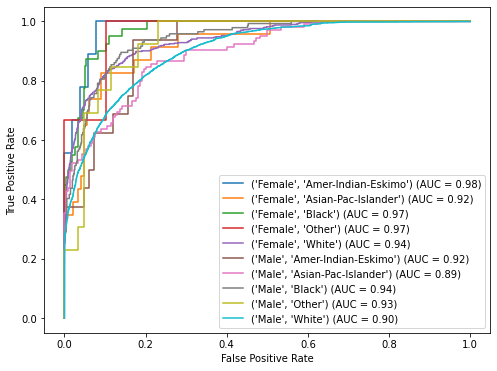

In [136]:
# Establish plot figure
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Plot ROC curves by group
rc = roc_auc(y_true, y_score, A_test)
by_group = rc.by_group()
display = rc.plot_by_group(ax=ax)


# Plot - Configued w/ Parameters

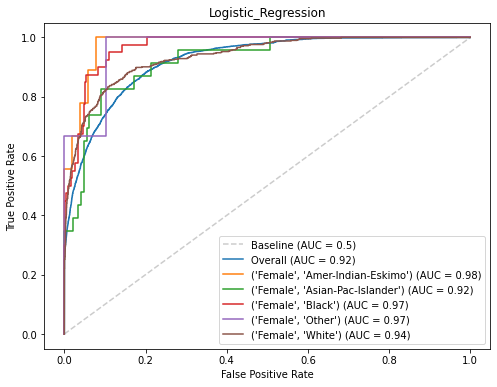

In [137]:
# Establish plot figure
plt.figure(figsize=(8, 6))
ax = plt.gca()

rc = roc_auc(y_true, y_score, A_test)
by_group = rc.by_group()
female_only = [x for x in by_group.index if 'Female' in x]
display = rc.plot_by_group( 
    sensitive_index=female_only, 
    estimator_name = "Logistic_Regression",
    ax=ax,
    include_overall=True,
    include_baseline=True,
)

In [138]:
rc.auc_by_group()

{('Female', 'Amer-Indian-Eskimo'): 0.9782135076252724,
 ('Female', 'Asian-Pac-Islander'): 0.9237641453245979,
 ('Female', 'Black'): 0.9689024390243902,
 ('Female', 'Other'): 0.9659863945578231,
 ('Female', 'White'): 0.9360880134378032,
 ('Male', 'Amer-Indian-Eskimo'): 0.9179216867469879,
 ('Male', 'Asian-Pac-Islander'): 0.8942403628117914,
 ('Male', 'Black'): 0.9402619949494949,
 ('Male', 'Other'): 0.9319041614123581,
 ('Male', 'White'): 0.9008740280446366}

In [139]:
rc.auc_by_group(female_only)

{('Female', 'Amer-Indian-Eskimo'): 0.9782135076252724,
 ('Female', 'Asian-Pac-Islander'): 0.9237641453245979,
 ('Female', 'Black'): 0.9689024390243902,
 ('Female', 'Other'): 0.9659863945578231,
 ('Female', 'White'): 0.9360880134378032}

In [140]:
vars(rc)

{'y_true': array([0, 0, 0, ..., 0, 0, 1]),
 'y_score': array([5.99642629e-02, 2.32096179e-04, 8.19842605e-03, ...,
        2.29681626e-03, 1.05706244e-01, 5.57529489e-01]),
 'sensitive_features':           sex                race
 20668  Female               White
 1722     Male               White
 39609  Female               White
 15858  Female               White
 41078    Male               White
 ...       ...                 ...
 27235  Female               Black
 35736    Male               Black
 44281  Female               White
 23359  Female  Amer-Indian-Eskimo
 32035    Male               White
 
 [16118 rows x 2 columns],
 'sensitive_series': sex     race              
 Female  Amer-Indian-Eskimo    ([0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,...
         Asian-Pac-Islander    ([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...
         Black                 ([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
         Other                 ([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,